In [3]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os


In [12]:
def detect_and_predict_mask(frame, faceNet,maskNet):
    (h,w)=frame.shape[:2]
    blob=cv2.dnn.blobFromImage(frame,1.0,(224,224), (104.0,177.0,123.0))
    
    faceNet.setInput(blob)
    detections=faceNet.forward()
    print(detections.shape)
    
    faces=[]
    locs=[]
    preds=[]
    
    for i in range(0,detections.shape[2]):
        confidence=detections[0,0,i,2]
        
        if confidence>0.5:
            box=detections[0,0,i,3:7]*np.array([w,h,w,h])
            (startX, startY,endX,endY)=box.astype('int')
            
            (startX,startY)=(max(0,startX), max(0,startY))
            (endX,endY)=(min(w-1, endX), min(h-1,endY))
            
            face=frame[startY:endY, startX:endX]
            face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
            face=cv2.resize(face,(224,224))
            face=img_to_array(face)
            face=preprocess_input(face)
            
            
    if len(faces>0):
            faces=np.array(faces,dtype='float32')
            preds=maskNet.predict(faces, batch_size=32)
            
    return (locs,preds)

In [8]:
prototxtPath=r"face_detector\deploy.prototxt"
weightsPath=r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet=cv2.dnn.readNet(prototxtPath,weightsPath)

In [9]:
maskNet=load_model('mask_detector.model')

In [13]:
print('[INFO] starting video stream.....')
vs=VideoStream(src=0).start()

while True:
    frame=vs.read()
    frame=imutils.resize(frame, width=400)
    (locs,preds)=detect_and_predict_mask(frame,faceNet, maskNet)
    
    for(box,pred) in zip(locs,preds):
        (startX, startY,endX,endY)=box
        (mask,withoutMask)=pred
        
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label =='Mask' else (0,0,255)
        
        label='{}: {:.2f}%'.format(label,max(mask,withoutMask)*100)
        
        cv2.putText(frame,label,(startX, startY-10),
        cv2.FONT_HERSHEY_COMPLEX,0.45,COLOR,2)
        cv2.rectangle(frae,(startX, startY), (endX,endY), color,2)
        
    cv2.imshow("Frame",frame)    
    key=cv2.waitKey(1)&0xFF
    
    if  key==ord('q'):
        break
        
cv2.destroyAllWindows()        
vs.stop()

[INFO] starting video stream.....
(1, 1, 200, 7)


TypeError: '>' not supported between instances of 'list' and 'int'

In [6]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [7]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,stratify=labels ,random_state=42)

In [9]:
#DATA AUGUMENTATION
aug=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

In [11]:
#loading MobileNetV2 network
baseModel=MobileNetV2(weights='imagenet',include_top=False,
                    input_tensor=Input(shape=(224,224,3)))

9412608/9406464 [==============================] - 26s 3us/step


In [12]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)



In [13]:
model=Model(inputs=baseModel.input, outputs=headModel)

In [14]:
for layer in baseModel.layers:
    layer.trainable=False

In [15]:
opt=Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt,
             metrics=['accuracy'])

In [18]:
H=model.fit(aug.flow(X_train, y_train, batch_size=BS),
                steps_per_epoch=len(X_train)//BS,
                validation_data=(X_test,y_test),
                validation_steps=len(X_test)//BS,
                epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 111s 1s/step - loss: 0.3596 - accuracy: 0.8434 - val_loss: 0.0959 - val_accuracy: 0.9778
Epoch 2/20
95/95 [==============================] - 85s 899ms/step - loss: 0.1085 - accuracy: 0.9614 - val_loss: 0.0594 - val_accuracy: 0.9844
Epoch 3/20
95/95 [==============================] - 85s 893ms/step - loss: 0.0884 - accuracy: 0.9733 - val_loss: 0.0451 - val_accuracy: 0.9883
Epoch 4/20
95/95 [==============================] - 85s 890ms/step - loss: 0.0771 - accuracy: 0.9763 - val_loss: 0.0404 - val_accuracy: 0.9870
Epoch 5/20
95/95 [==============================] - 85s 897ms/step - loss: 0.0574 - accuracy: 0.9796 - val_loss: 0.0370 - val_accuracy: 0.9870
Epoch 6/20
95/95 [==============================] - 85s 896ms/step - loss: 0.0459 - accuracy: 0.9852 - val_loss: 0.0326 - val_accuracy: 0.9909
Epoch 7/20
95/95 [==============================] - 85s 898ms/step - loss: 0.0440 - accuracy: 0.9835 - val_loss: 0.0352 - val_accuracy: 0.9883
E

In [19]:
##Evaluating model

In [20]:
pred=model.predict(X_test)

In [21]:
pred=np.argmax(pred,axis=1)

In [22]:
print(classification_report(y_test.argmax(axis=1),pred,target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [23]:
model.save("mask_detector.modelpao", save_format='h5')

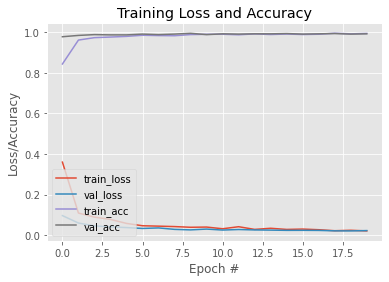

In [27]:
N=EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0,N), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0,N), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0,N), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')